# Assignment 9

### Geoffrey Lamb, Jiaqi Yu, Jialin Yu, Matthew Lipinski, Davis Nyabuti, Huiyu He, Tong Wu

#### SEIS 735-01 

#### November 29th, 2017

# Naive Bayes


# Tool Selection

## GraphLab

We used `graphlab` to pre-process the data. We chose graphlab for data pre-processing because it uses out of core data structures. This allows the application to load large files without running out of memory.

In total our dataset had a total of 2326856 rows with 17 variables. All variables except for **AGE** are categorical

## R

`R` has a rich library of predictive modeling algorithms which are well documented. It is also an easy to use language with good documentation.


## Required R packages

The following are the R packages are used in the application

In [1]:
options(java.parameters="-Xmx10g")
library (plyr)
library(rpart)
library(caret)
library(corrplot)
library(e1071)
library(data.table)
library(rpart.plot)

Loading required package: lattice
Loading required package: ggplot2
corrplot 0.84 loaded


## Load Data

In [2]:
# data
data <- fread('assignment_8_data.csv',sep = ",",header = T)

'%!in%' <- function(x,y)!('%in%'(x,y))

numeric_cols <- names(data) %in%  c("AGE")
non_numeric <- names(data) %!in% c("AGE","DESYNPUF_ID")
non_numeric <- names(data)[non_numeric]
non_numeric <- unlist(non_numeric, recursive = TRUE, use.names = FALSE)
df <- as.data.frame(data)

Read 2326856 rows and 18 (of 18) columns from 0.128 GB file in 00:00:05


### Decode values

- **1** denotes the presense of a condition
- **0** denotes the absense of the condition

In [3]:
# Make values easy to read
df$SP_DEPRESSN <- as.character(df$SP_DEPRESSN)
df$SP_DEPRESSN[df$SP_DEPRESSN == "1"] <- 'Yes'
df$SP_DEPRESSN[df$SP_DEPRESSN == "2"] <- 'No'
df$BENE_ESRD_IND[df$BENE_ESRD_IND == "0"] <- 'No'
df$SP_ALZHDMTA[df$SP_ALZHDMTA == "1"] <- 'Yes'
df$SP_ALZHDMTA[df$SP_ALZHDMTA == "2"] <- 'No'
df$SP_CHF[df$SP_CHF == "1"] <- 'Yes'
df$SP_CHF[df$SP_CHF == "2"] <- 'No'
df$SP_CNCR[df$SP_CNCR == "1"] <- 'Yes'
df$SP_CNCR[df$SP_CNCR == "2"] <- 'No'
df$SP_COPD[df$SP_COPD == "1"] <- 'Yes'
df$SP_COPD[df$SP_COPD == "2"] <- 'No'
df$SP_DIABETES[df$SP_DIABETES == "1"] <- 'Yes'
df$SP_DIABETES[df$SP_DIABETES == "2"] <- 'No'
df$SP_ISCHMCHT[df$SP_ISCHMCHT == "1"] <- 'Yes'
df$SP_ISCHMCHT[df$SP_ISCHMCHT == "2"] <- 'No'
df$SP_OSTEOPRS[df$SP_OSTEOPRS == "1"] <- 'Yes'
df$SP_OSTEOPRS[df$SP_OSTEOPRS == "2"] <- 'No'
df$SP_CHRNKIDN[df$SP_CHRNKIDN == "1"] <- 'Yes'
df$SP_CHRNKIDN[df$SP_CHRNKIDN == "2"] <- 'No'
df$SP_RA_OA[df$SP_RA_OA == "1"] <- 'Yes'
df$SP_RA_OA[df$SP_RA_OA == "2"] <- 'No'
df$SP_STRKETIA [df$SP_STRKETIA  == "1"] <- 'Yes'
df$SP_STRKETIA [df$SP_STRKETIA  == "2"] <- 'No'


By default the `read.csv(...)` function loaded all our predictors as numeric. However, some of these predictors are simply IDs that we need to convert to `factors`.

In [4]:
# create factors
df[non_numeric] <- lapply(df[non_numeric], factor)

data_y = df$SP_DEPRESSN
names(data_y) <- c("SP_DEPRESSN")

# Remove DESYNPUF_ID and SP_DEPRESSN from df
data_x = df[,non_numeric]
target_name <- names(data_x) %in% c("SP_DEPRESSN")
data_x = data_x[,!target_name]
data_x$AGE = df$AGE

data_xy = data_x
data_xy$SP_DEPRESSN = data_y

rm(data_x)
rm(data_y)
rm(df)
rm(data)
gc()

set.seed(1011)
# idx <- createFolds(data_y, returnTrain = TRUE)
ctrl <- trainControl(method = "cv", savePredictions = TRUE
                    ,summaryFunction = twoClassSummary)

used     (Mb)  gc trigger (Mb)  max used  (Mb) 
Ncells  2196165 117.3   6861544  366.5   4705830 251.4
Vcells 25151498 191.9 106012404  808.9 131053010 999.9

### High level data analysis

We use the `str(...)` function to view the structure of the data

In [5]:
str(data_xy)

'data.frame':	2326856 obs. of  17 variables:
 $ BENE_SEX_IDENT_CD: Factor w/ 2 levels "F","M": 2 2 2 2 1 1 1 2 2 1 ...
 $ BENE_RACE_CD     : Factor w/ 4 levels "Black","Hispanic",..: 4 4 4 4 4 4 4 4 1 1 ...
 $ BENE_ESRD_IND    : Factor w/ 2 levels "No","Y": 1 1 1 1 2 1 1 1 1 1 ...
 $ SP_STATE_CODE    : Factor w/ 52 levels "1","2","3","4",..: 37 3 16 25 33 10 10 44 1 5 ...
 $ BENE_COUNTY_CD   : Factor w/ 319 levels "0","1","10","11",..: 145 13 119 129 49 10 1 288 94 86 ...
 $ SP_ALZHDMTA      : Factor w/ 2 levels "No","Yes": 1 1 2 1 1 1 2 1 1 2 ...
 $ SP_CHF           : Factor w/ 2 levels "No","Yes": 2 2 2 1 2 1 1 1 1 2 ...
 $ SP_CHRNKIDN      : Factor w/ 2 levels "No","Yes": 1 1 1 1 2 1 1 1 2 2 ...
 $ SP_CNCR          : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 1 ...
 $ SP_COPD          : Factor w/ 2 levels "No","Yes": 1 1 2 1 2 1 1 1 1 2 ...
 $ SP_DIABETES      : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 1 1 1 1 ...
 $ SP_ISCHMCHT      : Factor w/ 2 levels "No","Yes": 1 1 1 1 

### Categorical variables

An analysis of the output above indicates that some categorical variabes have too many distinct values to create a sparse matrix. If we have to use these variables we would likely require more data. Additionally, inclusion of these variables would make the training process longer. We opted to remove them from the modeling process.

>**3.Your team can remove up to two columns (i.e. predictors) from your prediction task. Which two predictors your team will choose?**
* BENE_COUNTY_CD
* SP_STATE_CODE

In [6]:
tooManyLevels <- names(data_xy) %in% c("SP_STATE_CODE","BENE_COUNTY_CD")
data_xy <- data_xy[!tooManyLevels]
str(data_xy)

'data.frame':	2326856 obs. of  15 variables:
 $ BENE_SEX_IDENT_CD: Factor w/ 2 levels "F","M": 2 2 2 2 1 1 1 2 2 1 ...
 $ BENE_RACE_CD     : Factor w/ 4 levels "Black","Hispanic",..: 4 4 4 4 4 4 4 4 1 1 ...
 $ BENE_ESRD_IND    : Factor w/ 2 levels "No","Y": 1 1 1 1 2 1 1 1 1 1 ...
 $ SP_ALZHDMTA      : Factor w/ 2 levels "No","Yes": 1 1 2 1 1 1 2 1 1 2 ...
 $ SP_CHF           : Factor w/ 2 levels "No","Yes": 2 2 2 1 2 1 1 1 1 2 ...
 $ SP_CHRNKIDN      : Factor w/ 2 levels "No","Yes": 1 1 1 1 2 1 1 1 2 2 ...
 $ SP_CNCR          : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 1 ...
 $ SP_COPD          : Factor w/ 2 levels "No","Yes": 1 1 2 1 2 1 1 1 1 2 ...
 $ SP_DIABETES      : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 1 1 1 1 ...
 $ SP_ISCHMCHT      : Factor w/ 2 levels "No","Yes": 1 1 1 1 2 2 2 1 1 1 ...
 $ SP_OSTEOPRS      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ SP_RA_OA         : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 2 ...
 $ SP_STRKETIA      : Fac

### Create Test & Train datasets

In [7]:
set.seed(1011)
trainIndex <- createDataPartition(data_xy$SP_DEPRESSN, p = .7, 
                                  list = FALSE, 
                                  times = 1)
depTrain <- data_xy[ trainIndex,]
depTest  <- data_xy[-trainIndex,]

### Balance Train Data

In order for our model to generate relavant results, we need to balance the training data.

In [8]:
set.seed(1011)
train_bal <- downSample(x =  depTrain[,-ncol(depTrain)],
                       y = depTrain$SP_DEPRESSN)
table(train_bal$Class)


    No    Yes 
292889 292889 

# Naive Bayes model

Naive Bayes assumes independence between the predictor variables. From what we know about this data we know that the predictors (chronic conditions) are not independent. As a result, this is probably not the best model to use for this data.

In [9]:
classifier <- naiveBayes(train_bal$Class ~ ., data = train_bal)

## Model Evaluation
We used the ROC curve to evaluate the quality of our model

In [10]:
set.seed(1011)
pred <- predict(classifier, newdata= depTest, type = "class")

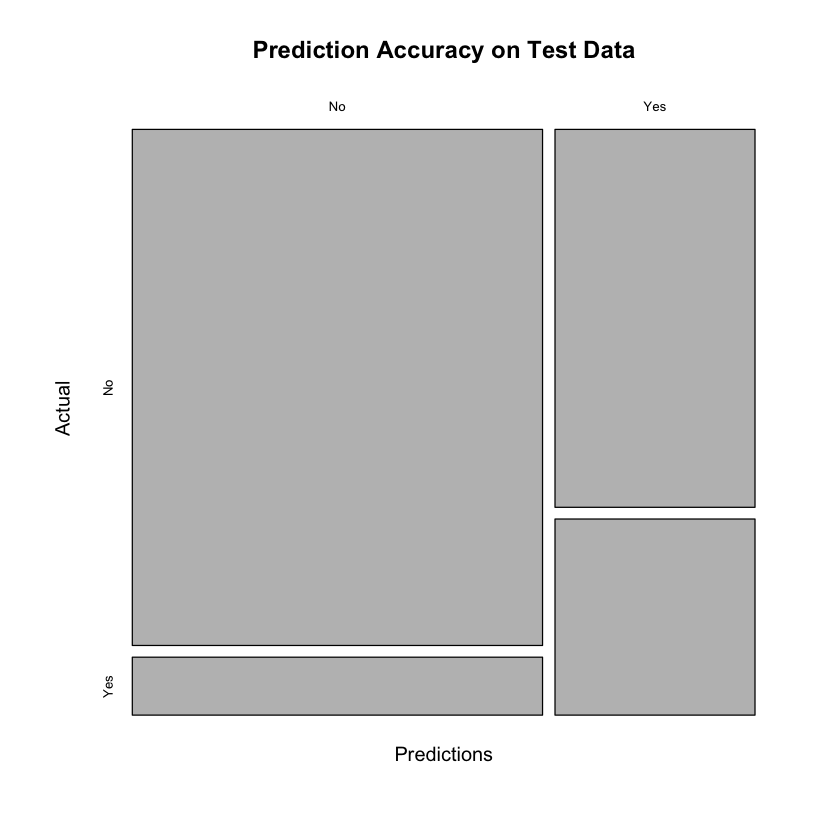

In [20]:
cfm <- confusionMatrix(depTest$SP_DEPRESSN, pred)
pred.table <- table("Predictions"= pred,  "Actual" = depTest$SP_DEPRESSN )
plot(pred.table, main="Prediction Accuracy on Test Data")

In [12]:
cfm$byClass

Sensitivity          Specificity       Pos Pred Value 
           0.8990681            0.3416310            0.7369217 
      Neg Pred Value            Precision               Recall 
           0.6226588            0.7369217            0.8990681 
                  F1           Prevalence       Detection Rate 
           0.8099596            0.6722627            0.6044100 
Detection Prevalence    Balanced Accuracy 
           0.8201820            0.6203496

### Predicting **No** Class
The results above indicate that our model was able to correctly predict the no class ~89% (*Sensitivity*) of the time. When we shouldn't have predicted **No** class we didn't for 34% (*SPecificity*) of the samples. This indicates that the model is poor in predicting the Yes class when the a sample belongs to the **Yes** class.

In [13]:
cfm.yes <- confusionMatrix(depTest$SP_DEPRESSN, pred, positive='Yes')
cfm.yes$byClass

Sensitivity          Specificity       Pos Pred Value 
           0.3416310            0.8990681            0.6226588 
      Neg Pred Value            Precision               Recall 
           0.7369217            0.6226588            0.3416310 
                  F1           Prevalence       Detection Rate 
           0.4411942            0.3277373            0.1119652 
Detection Prevalence    Balanced Accuracy 
           0.1798180            0.6203496

### Predicting Yes Class
We correctly predicted the Yes class 34% (*Sensitivity*) of the time. However, when we shouldn't have predicted the Yes class, we didn't on 89% (*Specificity*) of the samples.

### ROC Curve

In [14]:
nbprediction = predict(classifier, depTest, type='raw')

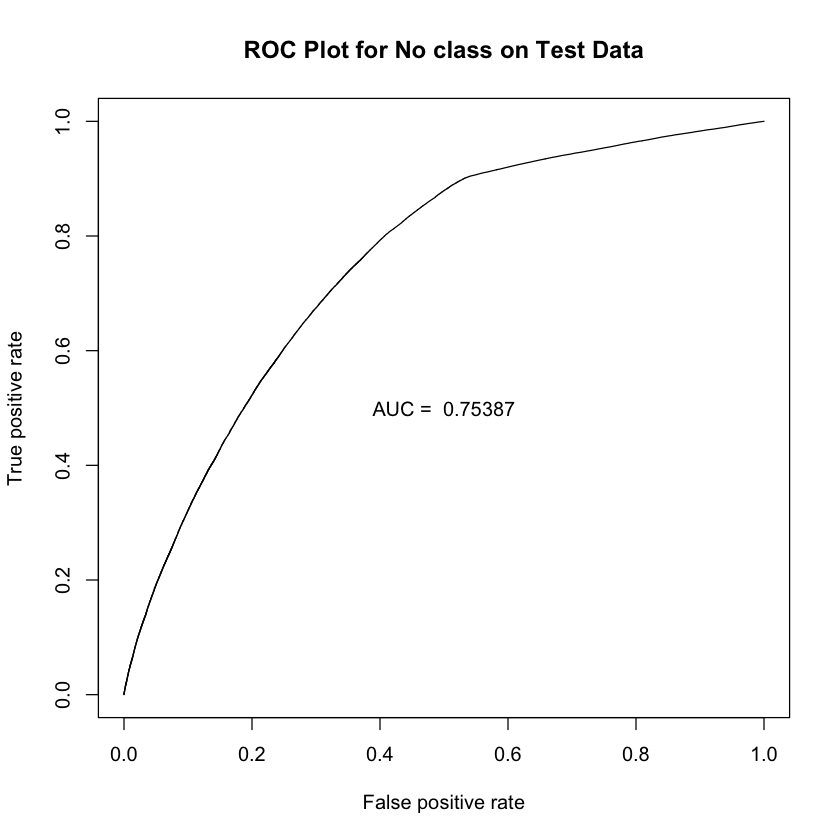

In [21]:
library(ROCR)
score = nbprediction[, 2]
actual.class = depTest[,'SP_DEPRESSN']
pred2 = prediction(score, actual.class)
perf_AUC=performance(pred2,"auc") #Calculate the AUC value
AUC=perf_AUC@y.values[[1]]
nb.prff = performance(pred2, "tpr", "fpr")
plot(nb.prff, main="ROC Plot for No class on Test Data")
text(0.5,0.5,paste("AUC = ",format(AUC, digits=5, scientific=FALSE)))

### Performance aganist training data
When we check the model performance aganist training data we find that it correctly predicts most of the No and Yes classes as expected because this is data that was used to build the model.

In [16]:
pred_train <- predict(classifier,train_bal,type = "class")

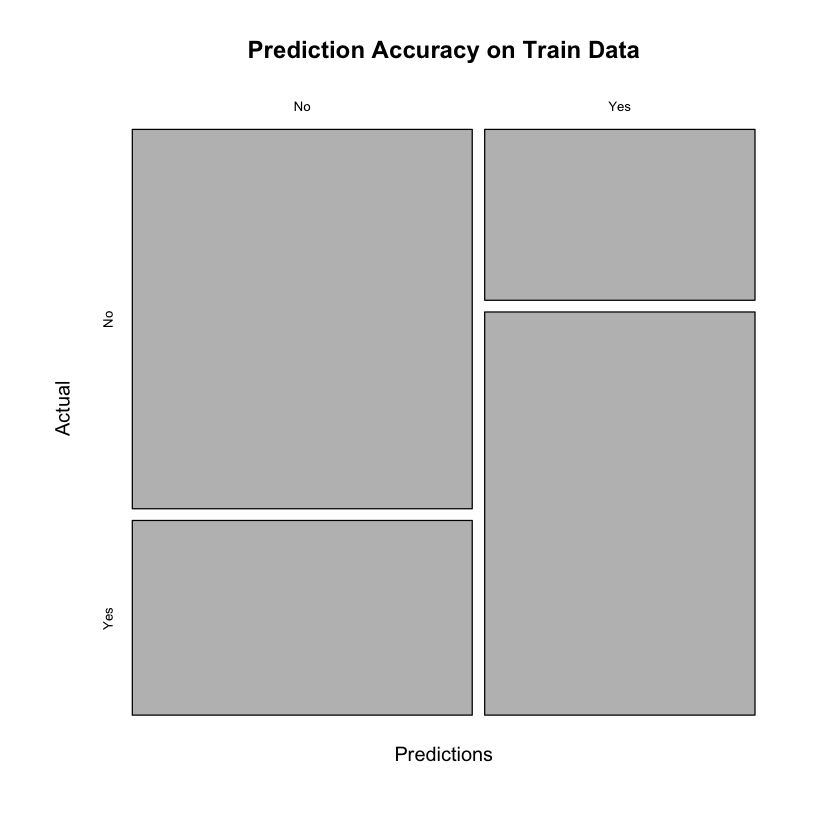

In [19]:
cfm_train <- confusionMatrix(train_bal$Class, pred_train)
pred_train.table <- table("Predictions"= pred_train,  "Actual" = train_bal$Class )
plot(pred_train.table, main="Prediction Accuracy on Train Data")

In [18]:
cfm_train

Confusion Matrix and Statistics

          Reference
Prediction     No    Yes
       No  215646  77243
       Yes 110654 182235
                                         
               Accuracy : 0.6792         
                 95% CI : (0.678, 0.6804)
    No Information Rate : 0.557          
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.3585         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.6609         
            Specificity : 0.7023         
         Pos Pred Value : 0.7363         
         Neg Pred Value : 0.6222         
             Prevalence : 0.5570         
         Detection Rate : 0.3681         
   Detection Prevalence : 0.5000         
      Balanced Accuracy : 0.6816         
                                         
       'Positive' Class : No             
                                         

## Conclusion

The ROC plot from test data indicates that the model performs well only when predicting the **No** class